# Try ResNet on a random sample of the NIH Chest X-ray dataset

The data were downloaded from here: https://www.kaggle.com/nih-chest-xrays/sample

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [5]:
# ROOT_DIR = Path(os.getcwd())
ROOT_DIR = Path("/aws-volume1/")
data_path = ROOT_DIR/"sample"

In [6]:
sample_labels = pd.read_csv(data_path/"sample_labels.csv")

In [7]:
sample_labels.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

Let's start with a small sub-sample

In [ ]:
sub_sample = sample_labels.head(100)
batch_size = 32 # raise this for larger dataset

In [ ]:
from fastai.vision import *

In [ ]:
data = (ImageList.from_df(df = sub_sample, path = data_path, cols = "Image Index", folder = "images")
        .split_by_rand_pct()
        .label_from_df(cols = "Finding Labels", label_delim='|')
        .transform(get_transforms())
        .databunch(bs = batch_size)
        .normalize(imagenet_stats)
       )

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
print("Number of classes: {}".format(len(data.classes)))
print("Class names: {}".format(data.classes))
print("c: {}".format(data.c))

# Now let's build a model

In [8]:
from fastai.vision import *
from fastai.metrics import fbeta

In [9]:
batch_size = 16
# 8 for stage 1, 4 for stage 2 on Razer
# 16 for everything on Tesla K80

In [10]:
data = (ImageList.from_df(df = sample_labels, path = data_path, cols = "Image Index", folder = "images")
        .split_by_rand_pct()
        .label_from_df(cols = "Finding Labels", label_delim='|')
        .transform(get_transforms())
        .databunch(bs = batch_size)
        .normalize(imagenet_stats)
       )

In [11]:
acc = partial(accuracy_thresh, thresh=0.2)
f_score= partial(fbeta, thresh=0.2)

In [12]:
learn = cnn_learner(data, models.resnet34, metrics = [acc, f_score])

In [ ]:
learn.fit_one_cycle(cyc_len=8)

In [13]:
learn.save("stage-1-resnet34-8_epochs")

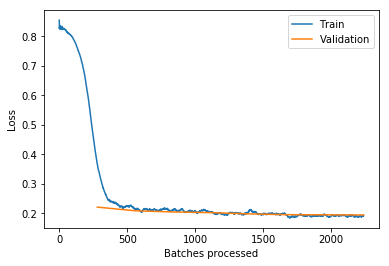

In [21]:
learn.recorder.plot_losses()

Losses don't get much below .2

In [ ]:
# learn.load("stage-1-resnet34")
# learn.load("stage-1-resnet34-higher_lr")
learn.load("stage-1-resnet34-8_epochs")

In [22]:
learn.unfreeze()

In [ ]:
learn.lr_find()

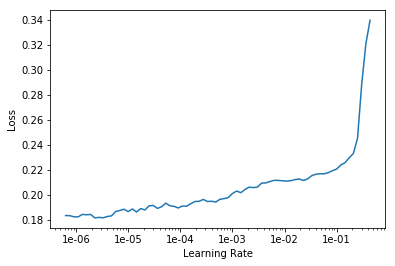

In [25]:
learn.recorder.plot()

*From JH:*  
This is a little bit harder to say what to look for because it tends to be this kind of shape where you get a little bit of upward and then it kind of very gradual downward and then up here. So I tend to kind of look for just before it shoots up and go back about 10x as a kind of a rule of thumb. So one 1e-5. That is what I do for the first half of my slice. And then for the second half of my slice, I normally do whatever learning rate are used for the the frozen part.  So lr which was 0.01 kind of divided by five or ten. Somewhere around that. That's my rule of thumb:

- look for the bit kind of at the bottom find about 10x smaller that's the number that I put as the first half of my slice
- `lr/5` or `lr/10`  is kind of what I put as the second half of my slice

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 5e-5))

Finally broke the .2 barrier!!

In [29]:
learn.save("stage-2-resnet34-8_epochs")

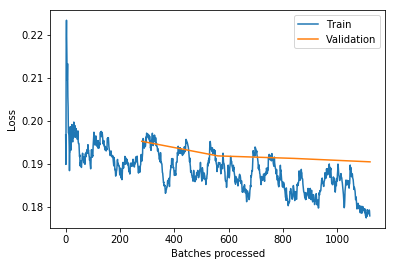

In [30]:
learn.recorder.plot_losses()

In [13]:
learn.load("stage-2-resnet34-8_epochs")

Learner(data=ImageDataBunch;

Train: LabelList (4485 items)
x: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,No Finding,Atelectasis,Cardiomegaly;Edema;Effusion,Consolidation;Mass
Path: /aws-volume1/sample;

Valid: LabelList (1121 items)
x: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: MultiCategoryList
No Finding,Effusion;Nodule,Atelectasis;Infiltration,No Finding,Infiltration
Path: /aws-volume1/sample;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Ba

## Compute F1 score to compare with Kaggle

In [30]:
f1 = partial(fbeta, thresh=0.2, beta=1) #f1 score for this task

In [28]:
probability_valid, cat_valid = learn.get_preds(DatasetType.Valid)

In [31]:
print("f1 on the validation set: {}".format( f1(probability_valid, cat_valid) ))

f1 on the validation set: 0.15137480199337006


Target is >.4. But the model is loading and training. Let's pull the fill dataset. :)